##### Importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
content_path = '/content_images/ramiz-dedakovic-RRpvivUOuJQ-unsplash.jpg'
style_path = '/style_images/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

##### Function to load the images

In [3]:
def load_img(image_path):
  max_dim = 700
  img = kp_image.load_img(image_path, color_mode='rgb')
  longer = max(img.size)
  scale = max_dim/longer
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img

##### Function the show the images

In [4]:
def img_show(img, title):
  out = np.squeeze(img, axis=0)
  out = out.astype('uint8')
  plt.imshow(out)
  plt.title(title)
  plt.imshow(out)

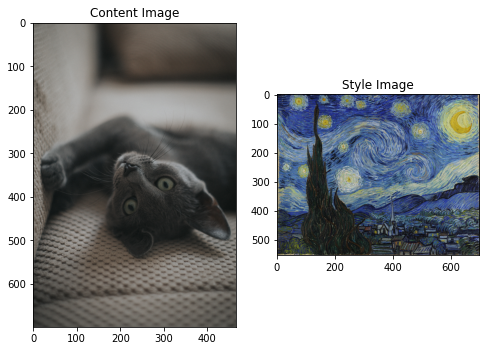

In [5]:
content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
img_show(content, 'Content Image')

plt.subplot(1, 2, 2)
img_show(style, 'Style Image')
plt.show()

##### Processing and de-processing

In [6]:
def load_and_preprocess_img(image_path):
  img = load_img(image_path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)

  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

##### Defining layers to be used 

In [7]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')  # using vgg19 pre-trained model
  vgg.trainable = False
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  return models.Model(vgg.input, model_outputs)

##### Function to calulate content loss

In [9]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

##### Function to calculate style loss

In [10]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram/tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  return tf.reduce_mean(tf.square(gram_style-gram_target))

In [11]:
def get_feature_representation(model, content_path, style_path) :
  content_image = load_and_preprocess_img(content_path)
  style_image = load_and_preprocess_img(style_path)

  style_outputs = model(style_image)
  content_outputs = model(content_image)

  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

##### Calculating combined loss

In [12]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0/float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer*get_style_loss(comb_style[0], target_style)

  weight_per_content_layer = 1.0/float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer*get_content_loss(comb_content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score
  return loss, style_score, content_score

In [13]:
def compute_grads(config):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**config)
  total_loss = all_loss[0]
  return tape.gradient(total_loss, config['init_image']), all_loss

##### Main function

In [14]:
import IPython.display

def run_style_transfer(content_path, style_path, num_iterations, content_weight=1e3, style_weight=1e-2):
  model = get_model()
  for layer in model.layers:
    layer.trainable = False
  
  style_features, content_features = get_feature_representation(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  init_image = load_and_preprocess_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)

  opt = tf.compat.v1.train.AdamOptimizer(learning_rate=6, beta1=0.99, epsilon=1e-1)

  loss_weights = (style_weight, content_weight)
  config = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  for i in range(num_iterations + 1):
    grads, all_loss = compute_grads(config)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
     
    if i%100 == 0:
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      print('After iteration: ', i)
      print('total loss: {:.4e}'.format(loss))
      print('style loss: {:.4e}'.format(style_score))
      print('content loss: {:.4e}'.format(content_score))

      IPython.display.display_png(Image.fromarray(plot_img))

  return plot_img

80142336/80134624 [==============================] - 1s 0us/step
After iteration:  0
total loss: 3.2017e+08
style loss: 3.2017e+08
content loss: 0.0000e+00


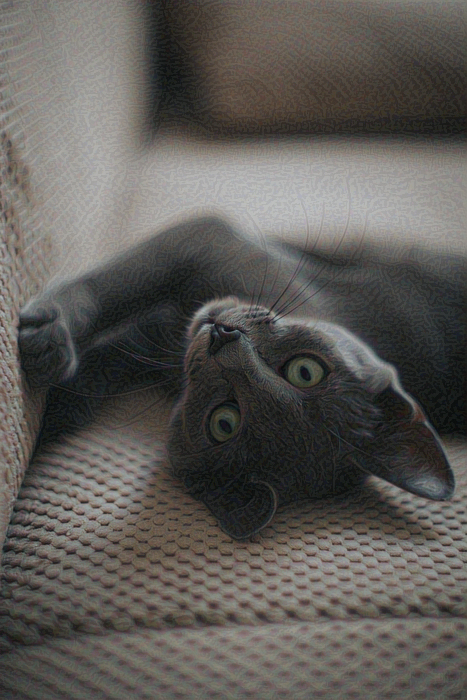

After iteration:  100
total loss: 4.5355e+06
style loss: 3.5150e+06
content loss: 1.0205e+06


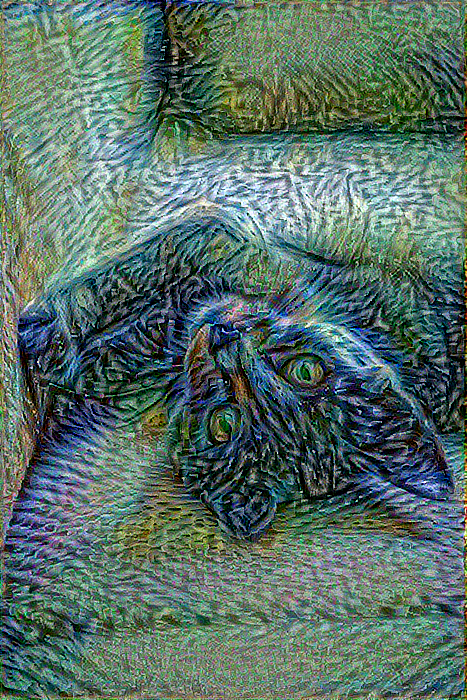

After iteration:  200
total loss: 1.7268e+06
style loss: 1.0367e+06
content loss: 6.9007e+05


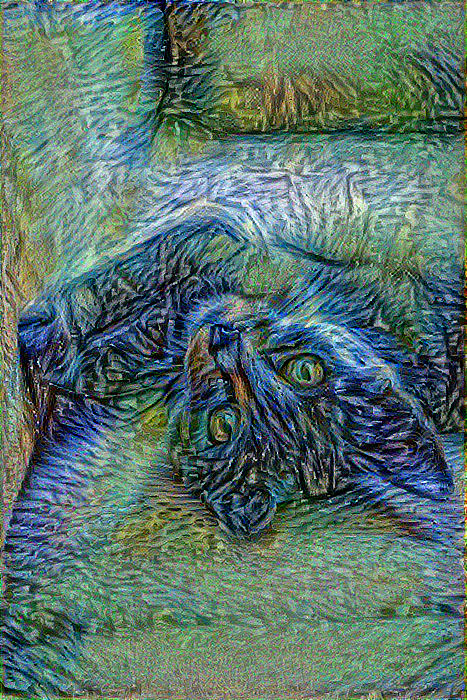

After iteration:  300
total loss: 9.5822e+05
style loss: 4.5580e+05
content loss: 5.0242e+05


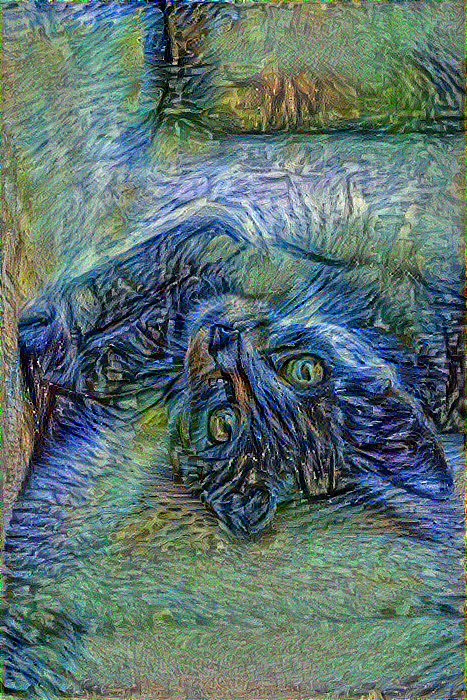

After iteration:  400
total loss: 6.5797e+05
style loss: 2.6593e+05
content loss: 3.9204e+05


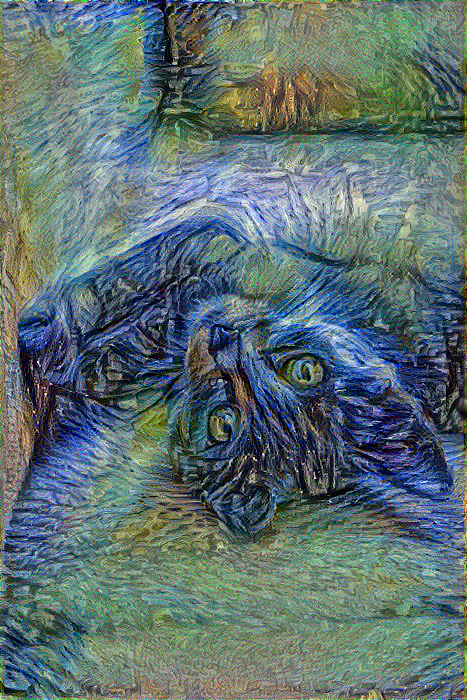

After iteration:  500
total loss: 5.1541e+05
style loss: 1.9081e+05
content loss: 3.2460e+05


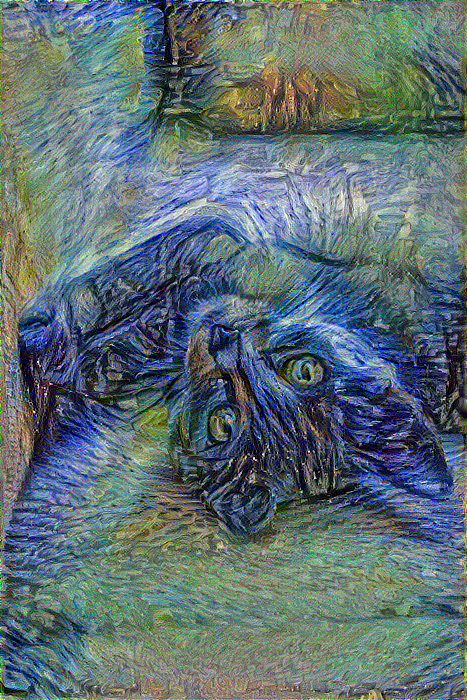

In [15]:
nst_image = run_style_transfer(content_path, style_path, num_iterations=500)

##### To save image

In [16]:
# Image.fromarray(nst_image).save('neural_styled_image.jpg')